# Deep Learning Project Report

Authors: 
-   Francesco Vaccari   francesco.vaccari@studenti.unitn.it [239927]
-   Gabriele Stulzer    gabriele.stulzer@studenti.unitn.it  []
-   Nicola Maestri      nicola.maestri@studenti.unitn.it [239920]

### Index
-   [Abstract](#abstract)
-   [Introduction](#introduction)
-   [Related Work](#related-work)
-   ...TODO

Sarebbe anche da spiegare dove abbiamo messo il codice, se lo abbiamo messo nell'appendice o tutto nel testo

### Abstract

Visual Grounding is a challenging task which aims to locate an object in an image based on a natural language query. Despite impressive advances in computer vision and natural language processing, establishing meaningful connections between distinct elements of images and text to get a good comprehension of context is still a big research area. In our work, we explored some new strategies to solve the problem by laveraging the image-text alignment of Clip as a foundation model for new frameworks specialized in Visual Grounding.

### Introduction

First, we propose a baseline that combines the object detector Yolo [1] and CLIP [2] model without any other component. For each candidate object proposed by Yolo is computed a cosine similarity with the text query and the most similar one is chosen as output prediction. We then tried to break free from the object detector developing a framework based on heatmaps [3] to retrieve the target object and on SAM [4] to draw a proper bounding box. We finally developed a new framework obtained by customizing the CLIP model to compute a low-level probability map from which we find a bounding box through some up-sampling convolutions [5]. Fine-tuning allowed us to exploit Clip strengths without the need for heavy training, therefore beyond the results, it seems to be the most promising direction.

### Related Work

- Visual Grounding
- Reffering Image Segmentation
- Adapters and Fine-tuning

## Dataset

## Baseline

## Baseline without Object Detector

This baseline presents an alternative pipeline that removes the necessity for an object detector. 
\
We employ the Lavis library to extract from each image a set of heat maps based on the text instances.
These are then used to identify some points with high confidence to belong to the target object.
Finally, we utilize SAM, Segment Anything Model, to obtain a mask of the whole object and the corresponding bounding box to return as output.

*Note:
\
The code presented below will provide more details about the implemantation, however we want to underline that we only scratched this idea with a basic pipeline. The proposed solution is naive and the system isn't able to get a really comprension of the relationship between text and image. Nevertheless it manages to achieve an acceptable accuracy without using Yolo, which was our first goal. We will try to move a step further in this direction with the model presented in the next section, although we decided to follow another approach.*


**Example**

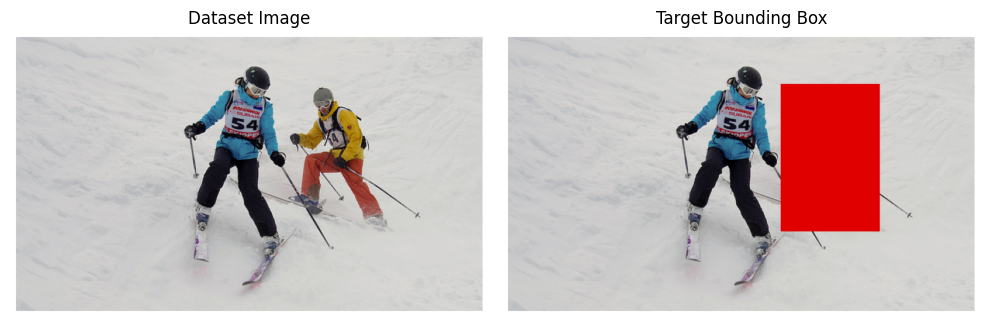

*Step 1: heatmap extraction based on the text query*

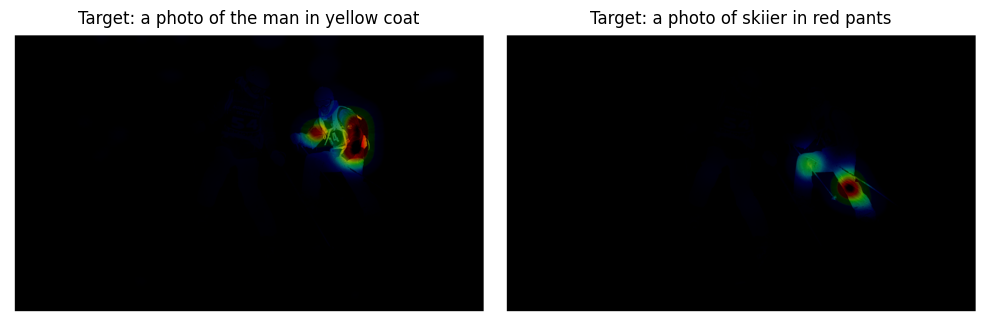

*Step 2: Bounding Box extraction based on SAM*

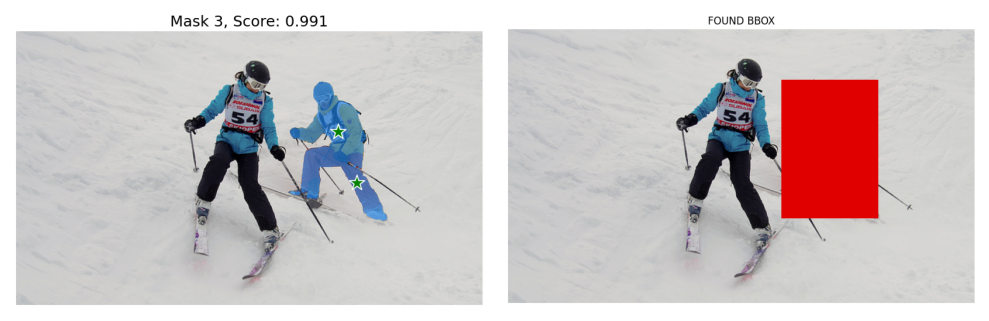

***BLIP: Boostraping Language Image Pretraining***

BLIP is a VLP framework with capable of visual-language understanding and caption generation. The model was presented in the lectures and further documentation is pointed here [ ]. In this baseline, it is used to retrieve an heat map based on the image and the sentence. Then, we simply apply a treshold to extract a unique stone and performe an average to get the position of the center. We initially worked on a similar structure for clip but we haven't completed it because we prefered to focus on other strategies, therefore the results presented relies on Blip model.

***SAM: Segment Anything Model***

Segment Anything Model (SAM) is an innovative deep learning model recently released by Meta. It is specialized in Segmentation and its capacity to obtain masks with different granularities is impressive. It can be employed for a wide range of tasks, in our case it is used to capture the whole object just passing to model some of its points. Code and other details can be found on the official website, on Github and in the paper [3].

### Observations

This baseline proves that it is not strictly necessary to use an object detector to perform Visual Grounding.
From the visual encoder, we can retrieve how much each pixel contributes to the similarity with the text query and use this to extract information about the relevant objcts in the scene.
\
The measured accuracy is 0.44%, where a bounding box is considered correctly classified if the $IoU \ge 0.5$.

A little of engineering pushed the performance up by 3%, showing there is a wide range for improvements. In particular, we add a preprocess of the image before to extract the heat maps. The original image is subdiveded in many fragments and for each text query the map is computed on the fragments which has higher similarity with the text.
\
Nevertheless, a big limitation of this baseline is that it consider pixels which are activated by the text but doesn't put more enfacies on the subject with respect to the context. We think a taylored network that takes as input the whole image concatenated with the heatmaps and combines this information with the text query could overcome this issue and achieve good performance. However, we decided to follow another method to relate the image and text. We present it in the last section.

## RISCLIP

In [5] the authors propose an interesting approach that adapts CLIP for the task of Referring Image Segmentation (RIS). The authors add in the model of CLIP Fusion and Backbone Adapters to improve RIS capablities, doing so allows to only train the block introduced while keeping the original CLIP framework frozen. This allows to exploit the rich and general image-text alignment that CLIP offers and is not as computationally expesinve as performing a full fine-tuning of the model. The Fusion adapters have the objective of allowing multi-modal communication between the visual and textual layers of transformers, while the Backbone Adapters inject new knowledgefor solving the task at hand.

In our project we replicated the structure of the model described in the paper [5] for the ViT-B/16 version of CLIP and adapted it to the task of Visual Grounding.

### The Model

The model consists of two main parts: Locator and Refiner. The Locator is the CLIP model with the addition of the Adapters and a minor changes to produce a different output than the standard implementation. The Locator takes as input the image already patchified and outputs a probability map with the same shape of the input. Then the Refiner, consisting of a series of up-sampling operations, turns the the probability map into a pixel-level probability map from which the final bounding box is extracted.

The probability map is obtained by computing the cosine similarity between the textual representation of the query and the visual representation of each patch. This differs from the standard CLIP model where the image was encoded into a single token summarizing the content of the image. In our particular case, with the ViT-B/16 version of CLIP being used, the probability map will contain a grid of 14x14 values of similarity which tell us where in the image the object referred by the query is most likely located. The Refiner then performs the up-sampling givin as output an higher resolution probability map.

The figure below shows the structure of the model.

<p align="center">
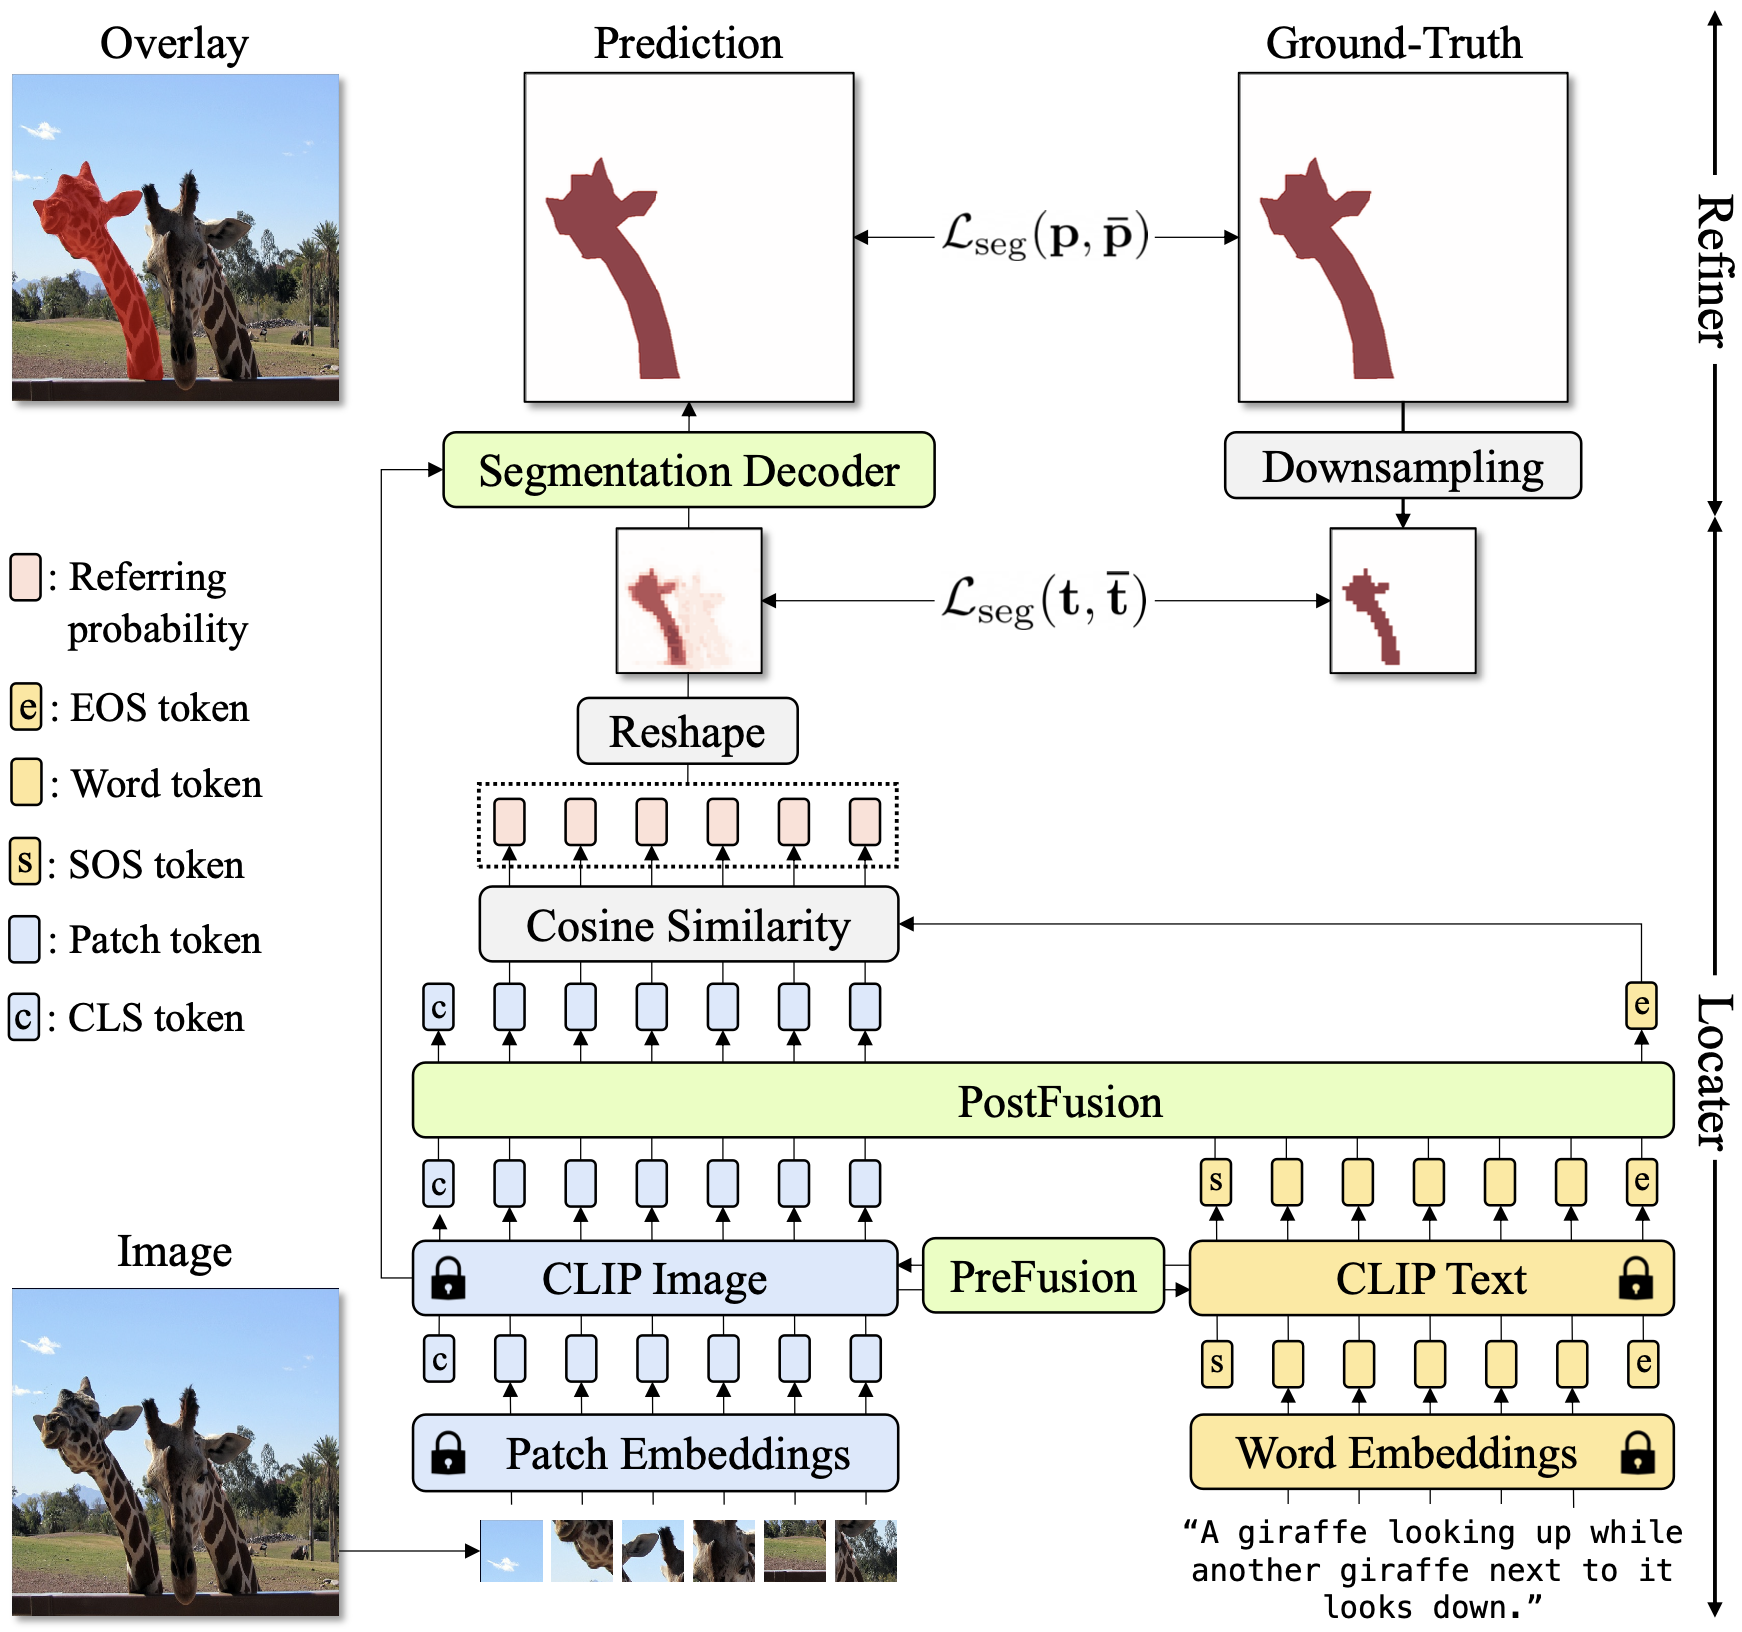
</p>

### Locator

We can identify three main components in the Locator network: CLIP backbone, Backbone Adapters and Fusion Adapters. The CLIP backbone is simply a CLIP model on top o which adapters are added to fine tune for the specific task. For the purpose of explaining where the adapters are added, let us remind the CLIP architecture. CLIP consists of two main channels, image encoder and text encoder, which are both composed of multiple consecutive layers of transformer blocks, 12 for each encoder in the specific version we used. Each transformer block can be divided into two submodules: multi-head self-attention (MHSA) and multi-layer perceptron (MLP), each preceded by a normalization layer (LN). The forward pass for the $i_{th}$ block is as follows:

$$
\bar{f}_{i} = \text{MHSA}(\text{LN}(f_{i-1})) + f_{i-1}
$$
$$
f_{i} = \text{MLP}(\text{LN}(\bar{f}_{i})) + \bar{f}_i
$$

Where $f_{i-1}$ is the output of the previous block and $f_{i}$ will be the input for the next block.

#### Backbone Adapters

The Backbone Adapters are added to the CLIP backbone to improve the model capabilities for our task. They consists of a down-projection linear layer, a non-linear activation, and an up-projection linear layer to the original dimension. This structure is added in a residual way both after the MHSA and the MLP submodules of each transformer block that compose either the visual or textual encoders. With $\text{AD}_{\text{MHSA}}$ representing the adapter added after the MHSA submodule and $\text{AD}_{\text{MLP}}$ the adapter added after the MLP submodule, the forward pass for the $i_{th}$ transformer block is as follows:

$$
\bar{f}_{i} = \text{AD}_{\text{MHSA}}(\text{MHSA}(\text{LN}(f_{i-1})) + f_{i-1}) + \text{MHSA}(\text{LN}(f_{i-1})) + f_{i-1}
$$
$$
f_{i} = \text{AD}_{\text{MLP}}(\text{MLP}(\text{LN}(\bar{f}_{i})) + \bar{f}_i) + \text{MLP}(\text{LN}(\bar{f}_{i})) + \bar{f}_i
$$

#### Fusion Adapters

Fusion Adapters allow text and image features to communicate and fuse the cross-model information coming from the two encoders. This cross-modal fusion can be performed both during the encoding phase, between same level layers of transformer blocks, or can be performed once the encoding is completed, between the outputs of last layer. For the first case, we will refer to the fusion adapters as PreFusion Adapters, in the second case as PostFusion Adapters. Much like for the Backbone Adapters, the output of the fusion adapters is added in a residual way to the original features.

For both PreFusion and PostFusion Adapters a linear normalization layer is applied before every shared space projection, cross-attention, multi-head self-attention or multi-layer perceptron module. For simplicity we will not report these layers in the equations.

##### PreFusion Adapters

The PreFusion Adapters let two transformer blocks, one from each encoder at layer $i$, communicate. Since a single adapter receives as input features coming from both modalities, first a linear projection to a shared dimension is applied ($W_{v2s}$ and $W_{t2s}$), then two separate cross-attention modules proced visual and textual multi-modal features (MHA), that are lastly projected back to the original dimension ($W_{s2v}$ and $W_{s2t}$). In the cross-attention module, to produce for example the multi-modal features that will be given back to the visual encoder, we set the original image features as the query, while the text features are used as key and value; the opposite happens for the textual encoder. The computation to obtain the cross-modal image features for the $i_{th}$ layer is as follows:

$$
s^{v}_{i} = W_{v2s}f^{v}_{i} , \quad s^{t}_{i} = W_{t2s}f^{t}_{i}
$$
$$
q^{v} = W_{q}s^{v}_{i} , \quad k^{t} = W_{k}s^{t}_{i} , \quad v^{t} = W_{v}s^{t}_{i}
$$
$$
m^{v}_{i} = \text{MHA}(q^{v} , k^{t}, v^{t})
$$
$$
\bar{f}^{v}_{i} = W_{s2v}m^{v}_{i}
$$

The same computation but with roles reversed is performed to obtain the cross-modal textual features. The outputs are then added to the original features in a residual way for both modalities:

$$
f^{v}_{i} = f^{v}_{i} + \bar{f}^{v}_{i}
$$
$$
f^{t}_{i} = f^{t}_{i} + \bar{f}^{t}_{i}
$$

The figure below shows the PreFusion Adapters structure.

<p align="center">
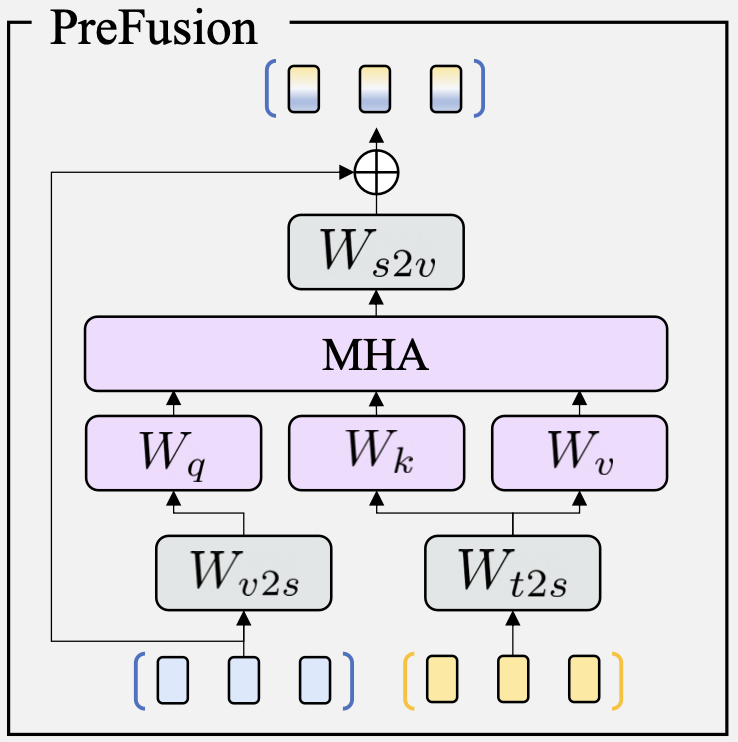
</p>

##### PostFusion Adapters

The PostFusion Adapters are attached after CLIP and take as input the final testual and visual encoder features, already projected in a shared dimension. These adapters apply cross-attention (MHA), multi-head self-attention (MHSA) and a multi-layer perceptron (MLP), each preceded by a normalization layer (LN). A single Adapter is composed of these operations, as suggested in the paper we stacked 6 of them to obtain the final image and text features with which compute the probability map.

The cross-attention is performed in the same way as in the PreFusion Adapters. Given the input features $f^{v}$ and $f^{t}$, the output of the $i_{th}$ adapter is computed as follows:

$$
{f}^{v}_{i} = \text{LN}^{v}_{1}(f^{v}_{i-1}), \quad
{f}^{t}_{i} = \text{LN}^{t}_{1}(f^{t}_{i-1})
$$
$$
{f}^{v}_{i} = \text{MHA}^{v}(q={f}^{v}_{i}, k={f}^{t}_{i}, v={f}^{t}_{i}) + {f}^{v}_{i}, \quad
{f}^{t}_{i} = \text{MHA}^{t}(q={f}^{t}_{i}, k={f}^{v}_{i}, v={f}^{v}_{i}) + {f}^{t}_{i}
$$
$$
{f}^{v}_{i} = \text{MHSA}^{v}(\text{LN}^{v}_{2}({f}^{v}_{i})) + {f}^{v}_{i}, \quad
{f}^{t}_{i} = \text{MHSA}^{t}(\text{LN}^{t}_{2}({f}^{t}_{i})) + {f}^{t}_{i}
$$
$$
{f}^{v}_{i} = \text{MLP}^{v}(\text{LN}^{v}_{3}({f}^{v}_{i})) + {f}^{v}_{i}, \quad
{f}^{t}_{i} = \text{MLP}^{t}(\text{LN}^{t}_{3}({f}^{t}_{i})) + {f}^{t}_{i}
$$


The figure below shows the PostFusion Adapters structure.

<p align="center">
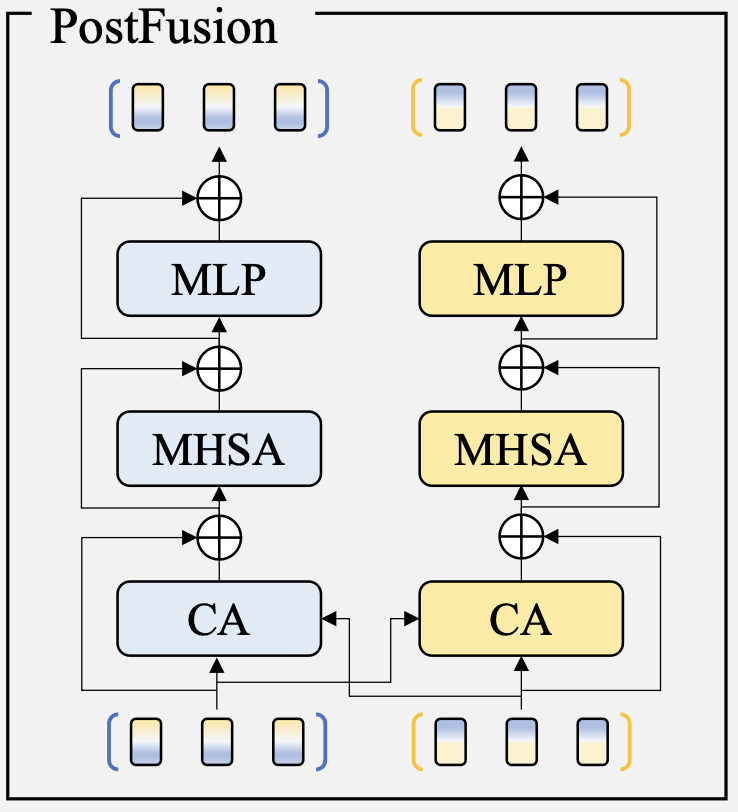
</p>

#### Probability Map

After the image and the sentence are processed by CLIP with the adapters added, the output of the Locator is a probability map containing 14x14 values. To understand how this map is produced, first let us talk about how both the image and text embeddings are shaped in the last layer of CLIP and what the tokens in each encoding represents. The image encoding has shape Bx197xD, where B is the batch size, D is the dimension of the embedding, and 197 is the number of tokens that are used for the specific version of CLIP we used. In particular, out of these 197 tokens, the first one is called CLS token and contains cumulative information coming from the whole image and is normally the output of CLIP, while the other 196 tokens, the ones we are interested in, are the tokens corresponding each to the 14x14 grid of patches the original image was divided in. The text embedding is instead of size BxLxD, where L is the lenght of the sentence and D is the dimension of the textual embedding. In this case, we are interested only in the last token of the sequence L which is the EOS token (end-of-sentence) that contains the summary of the information contained in the sentence.

Once obtained the tensors of shape 196xD and 1xD, one for each image and sentence associated, we compute the cosise similarity between each patch token of the image embedding and the single token coming from the text embedding, obtaining a vector of 196 values that we reshape as a 14x14 map. This map can be considered as a probability map for where the object, described in the sentence, is located in the image. In particular, the higher the value of a patch in the map, the higher the probability that the object is located in that patch. This map is the given as input to the Refiner.

Below, the image on the left is the input of the Locator, while on the right is the probability map produced as output.

<p align="center">
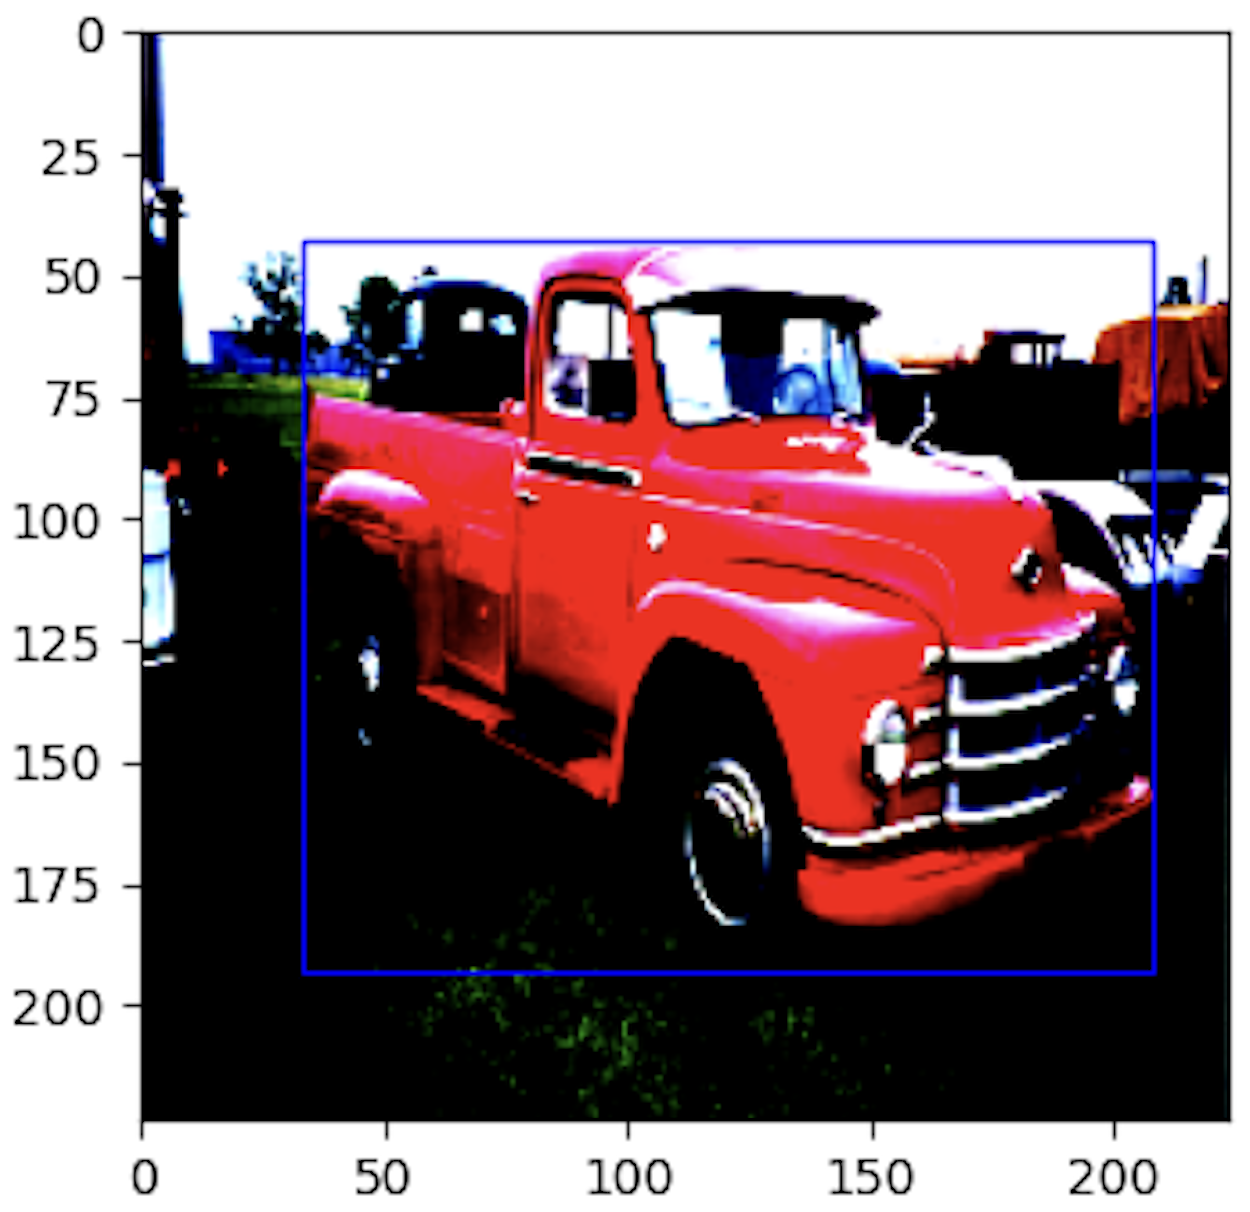
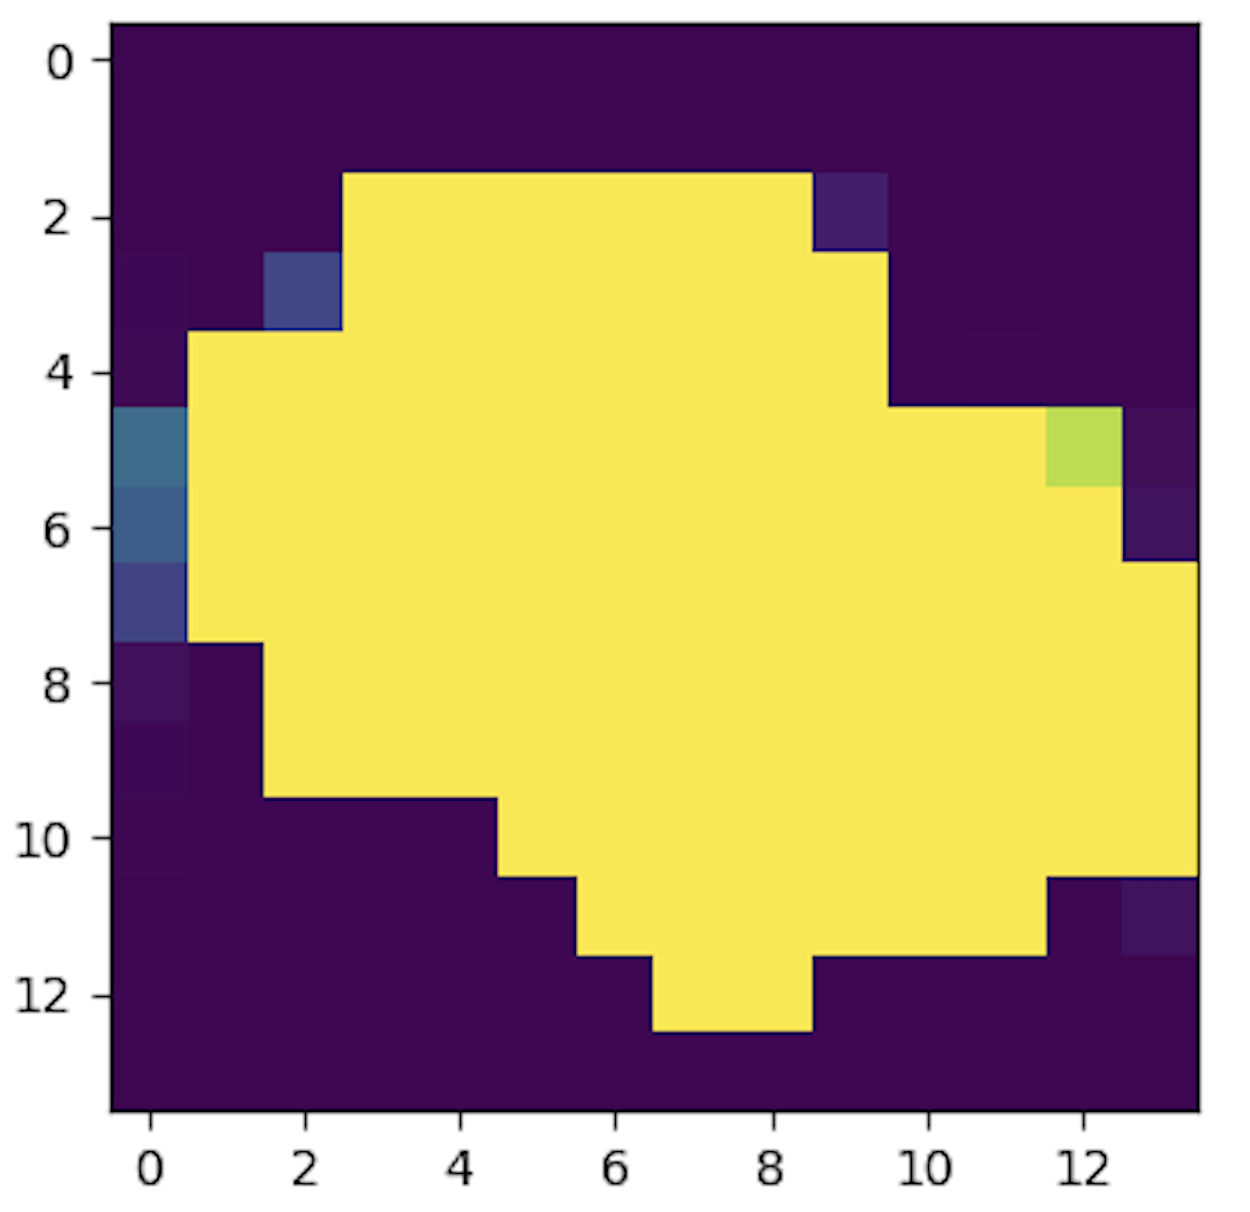
</p>

### Refiner

### Training

#### Loss Function

### Evaluation

#### Demonstration

#### Results (both qualitative and quantitative)

File per il modello: adapters, refiner, model, clip, simple_tokenizer. Di questi parlare solo dei primi tre, il resto non è importante.

Del dataset in teoria ne abbiamo già parlato sopra quindi non serve.

File per training: focaldiceloss, training_locator, training_refiner

File per inference/evaluation: tester

Infine risultati


## Conclusion

## References

1. Redmon, Joseph, Santosh Divvala, Ross Girshick, and Ali Farhadi. "You only look once: Unified, real-time object detection." In Proceedings of the IEEE conference on computer vision and pattern recognition, pp. 779-788. 2016.

2. Radford, Alec, Jong Wook Kim, Chris Hallacy, Aditya Ramesh, Gabriel Goh, Sandhini Agarwal, Girish Sastry et al. "Learning transferable visual models from natural language supervision." In International conference on machine learning, pp. 8748-8763. PMLR, 2021.

3. Li, Junnan, Dongxu Li, Caiming Xiong, and Steven Hoi. "Blip: Bootstrapping language-image pre-training for unified vision-language understanding and generation." In International Conference on Machine Learning, pp. 12888-12900. PMLR, 2022.

4. Kirillov, Alexander, Eric Mintun, Nikhila Ravi, Hanzi Mao, Chloe Rolland, Laura Gustafson, Tete Xiao et al. "Segment anything." arXiv preprint arXiv:2304.02643 (2023).

5. Kim, Seoyeon, Minguk Kang, and Jaesik Park. "RISCLIP: Referring Image Segmentation Framework using CLIP." arXiv preprint arXiv:2306.08498 (2023).

6. Vaswani, Ashish, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Łukasz Kaiser, and Illia Polosukhin. "Attention is all you need." Advances in neural information processing systems 30 (2017).


Per aggiungere una citazione andare su https://scholar.google.com , cercare il nome del paper, una volta trovato premere sul pulsantino "Cite" e copiare la citazione nello stile Chicago. Si prega di non cambiare i numeri già messi

## Appendix

Qua pensavo di metterci tutto quello che non mettiamo direttamente nel report, quindi codice che abbiamo scritto/modificato che però non è il punto centrale. Ci possiamo mettere anche risultati secondari.